In [111]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
OUTPUT_DIR = "/data/patrick_res/glm"

In [113]:
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [124]:
feedback_idxs = np.arange(13, 28, 1)
choice_idxs = np.arange(0, 13, 1)

In [125]:
alpha = 0.01
def get_res_per_session(row):
    session = row.session_name
    separate_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_separate.pickle"))
    separate_res["TimeIdxs"] = (separate_res["TimeBins"] * 10).astype(int)
    separate_res = separate_res.rename(columns={"score": "separate_score"})

    interaction_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_interaction.pickle"))
    interaction_res["TimeIdxs"] = (interaction_res["TimeBins"] * 10).astype(int)
    interaction_res = interaction_res.rename(columns={"score": "interaction_score"})

    shuffled_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_shuffles.pickle"))        
    shuffled_res["TimeIdxs"] = (shuffled_res["TimeBins"] * 10).astype(int)

    sig_stats = glm_utils.calculate_sig_stats(shuffled_res, alpha, 1)
    sig_stats["TimeIdxs"] = (sig_stats["TimeBins"] * 10).astype(int)

    merged = pd.merge(separate_res, interaction_res, on=["UnitID", "TimeIdxs"])
    merged = pd.merge(merged, sig_stats, on=["UnitID", "TimeIdxs"])

    pos = spike_utils.get_unit_positions_per_sess(session)
    pos = pos.fillna("unknown")
    pos = spike_utils.get_manual_structure(pos)

    with_pos = pd.merge(merged, pos, on=["UnitID"])
    with_pos["PseudoUnitID"] = int(session) * 100 + with_pos["UnitID"]
    return with_pos[["PseudoUnitID", "TimeBins", "TimeIdxs", "separate_score", "interaction_score", "sig_bound", "manual_structure"]]

In [122]:
unit_res = pd.concat(sessions.apply(get_res_per_session, axis=1).values).reset_index(drop=True)


In [110]:
unit_res.TimeBins.unique()

array([0. , 0.1, 0.2, 0.4, 0.5, 0.8, 0.9, 1. , 1.1, 1.3, 1.5, 1.6, 1.8,
       2. , 2.1, 2.2, 2.5, 2.6, 2.7])

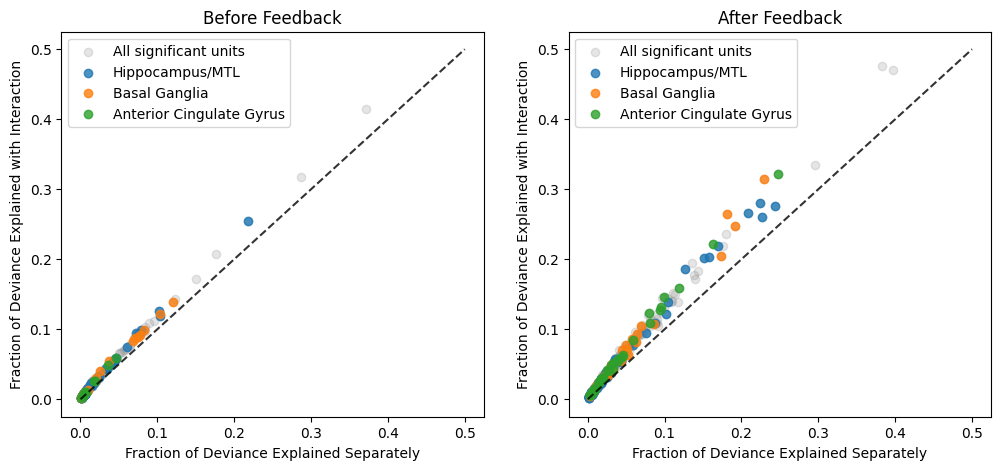

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
titles = ["Before Feedback", "After Feedback"]
for i, time_idxs in enumerate([choice_idxs, feedback_idxs]):
    ax = axs[i]
    time_unit_res = unit_res[unit_res.TimeIdxs.isin(time_idxs)]
    def get_max(group):
        return group.loc[group.interaction_score.idxmax()]
    maxes = time_unit_res.groupby("PseudoUnitID").apply(get_max)

    sig_units = maxes[maxes.interaction_score > maxes.sig_bound]
    # non_sig_units = maxes[maxes.interaction_score <=maxes.sig_bound]
    # ax.scatter(non_sig_units.separate_score, non_sig_units.interaction_score, alpha=0.8)
    ax.scatter(sig_units.separate_score, sig_units.interaction_score, alpha=0.2, color="gray", label="All significant units")
    for area in ["Hippocampus/MTL", "Basal Ganglia", "Anterior Cingulate Gyrus"]:
        area_units = sig_units[sig_units.manual_structure == area]
        ax.scatter(area_units.separate_score, area_units.interaction_score, alpha=0.8, label=area)
    ax.legend()
    ax.set_xlabel("Fraction of Deviance Explained Separately")
    ax.set_ylabel("Fraction of Deviance Explained with Interaction")

    ax.set_title(titles[i])
    ax.plot(np.arange(0, 0.6, 0.1), np.arange(0, 0.6, 0.1), linestyle="--", color="black", alpha=0.8)

In [137]:
time_unit_res = unit_res[unit_res.TimeIdxs.isin(feedback_idxs)]

interesting_units = time_unit_res[time_unit_res.interaction_score > 0.1]


In [138]:
time_unit_res.TimeBins.unique()

array([1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7])

In [ ]:
interesting_units["ratio"] = interesting_units.interaction_score / interesting_units.separate_score

In [ ]:
interesting_units.sort_values(by="ratio", ascending=False)[:50]